In [29]:
!pip3 install shap
!pip install lime

In [30]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.inspection import permutation_importance
import shap
from shap import TreeExplainer
import matplotlib.pyplot as plt
import lime
from lime.lime_tabular import LimeTabularExplainer

# Problem 1 

## i)

In [4]:
data = load_breast_cancer()

In [5]:
data

{'data': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
         1.189e-01],
        [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
         8.902e-02],
        [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
         8.758e-02],
        ...,
        [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
         7.820e-02],
        [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
         1.240e-01],
        [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
         7.039e-02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0

In [6]:
X = data["data"]
y = data["target"]

In [7]:
print(X.shape)
print(y.shape)

(569, 30)
(569,)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)

In [9]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [10]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.84      0.90        61
           1       0.92      0.99      0.95       110

    accuracy                           0.94       171
   macro avg       0.95      0.91      0.93       171
weighted avg       0.94      0.94      0.93       171



In [11]:
feature_names = data.feature_names
mdi_importances = pd.Series(
    clf.feature_importances_, index=feature_names
).sort_values(ascending=True)

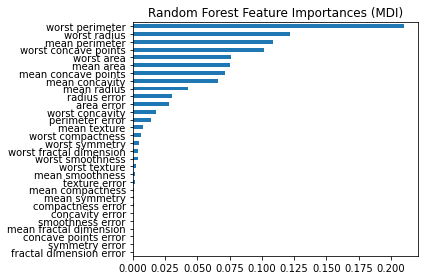

In [12]:

ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()


## ii)

### Train

In [13]:
r_train = permutation_importance(clf, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

In [15]:
for i in r_train.importances_mean.argsort()[::-1]:
    if r_train.importances_mean[i] - 2 * r_train.importances_std[i] > 0:
        print(f"{data.feature_names[i]:<8}"
              f"{r_train.importances_mean[i]:.3f}"
              f" +/- {r_train.importances_std[i]:.3f}")

worst perimeter0.019 +/- 0.009
worst concave points0.014 +/- 0.004
worst compactness0.003 +/- 0.001
worst fractal dimension0.002 +/- 0.001


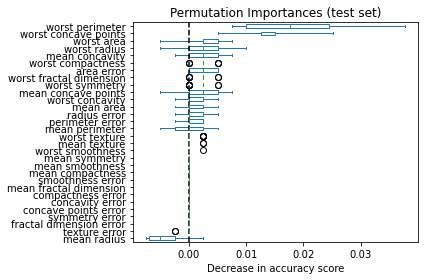

In [16]:
sorted_importances_idx = r_train.importances_mean.argsort()
importances = pd.DataFrame(
    r_train.importances[sorted_importances_idx].T,
    columns=data.feature_names[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

### Test

In [17]:
r_test = permutation_importance(clf, X_test, y_test,
                            n_repeats=30,
                            random_state=0)

In [18]:
for i in r_test.importances_mean.argsort()[::-1]:
    if r_test.importances_mean[i] - 2 * r_test.importances_std[i] > 0:
        print(f"{data.feature_names[i]:<8}"
              f"{r_test.importances_mean[i]:.3f}"
              f" +/- {r_test.importances_std[i]:.3f}")

worst concave points0.015 +/- 0.007
worst concavity0.012 +/- 0.005
worst fractal dimension0.011 +/- 0.003
worst compactness0.010 +/- 0.003
worst smoothness0.005 +/- 0.002


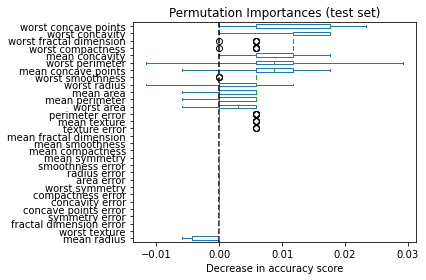

In [19]:
sorted_importances_idx = r_test.importances_mean.argsort()
importances = pd.DataFrame(
    r_test.importances[sorted_importances_idx].T,
    columns=data.feature_names[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

### Comparisson

## iii) 

## iv)

#### Shap

In [20]:
# load JS visualization code to notebook
shap.initjs()

# Create the explainer
explainer = TreeExplainer(clf)

shap_values = explainer.shap_values(X_test)

Variable Importance Plot - Global Interpretation


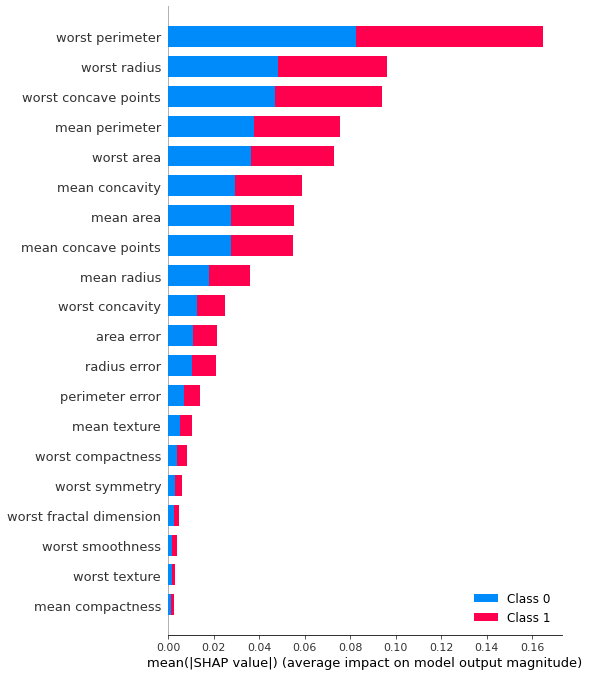

In [22]:
print("Variable Importance Plot - Global Interpretation")
figure = plt.figure()
shap.summary_plot(shap_values, X_test, feature_names=data.feature_names) 

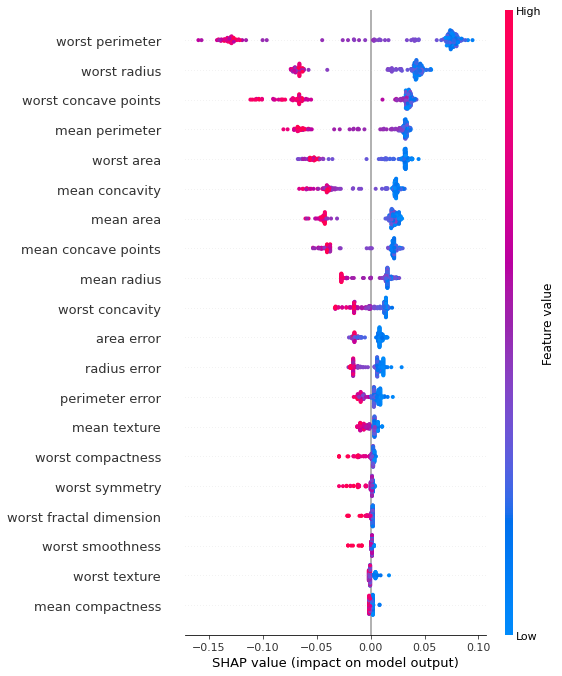

In [24]:
shap.summary_plot(shap_values[1], X_test, feature_names=data.feature_names)

In [26]:
shap.dependence_plot('worst perimeter', shap_values[1], X_test, interaction_index="worst perimeter")

ValueError: Could not find feature named: worst perimeter

### Lime

In [32]:
# Import the LimeTabularExplainer module


# Get the class names
class_names = ['Has diabetes', 'No diabetes']

# Get the feature names
feature_names = list(X_train.columns)

# Fit the Explainer on the training data set using the LimeTabularExplainer 
explainer = LimeTabularExplainer(X_train.values, feature_names = feature_names, 
                                 class_names = class_names, mode = 'classification')


#Perform the explanation on the 8th instance in the test data
explaination = explainer.explain_instance(X_test.iloc[8], rf_clf.predict_proba)

# show the result of the model's explaination
explaination.show_in_notebook(show_table = True, show_all = False)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

# Problem 2 

## i)

## ii)